In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle

c:\Users\MahmoodThe3rd\anaconda3\envs\py39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\MahmoodThe3rd\anaconda3\envs\py39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\MahmoodThe3rd\anaconda3\envs\py39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Load Data

In [2]:
def load_data():
    return pd.read_csv('../data/arima_df.csv').set_index('date')

ts_data = load_data()

In [3]:
ts_data.index = pd.to_datetime(ts_data.index)

# SARIMAX Modeling

In [4]:
def get_scores(data):
    
    model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.forecast[-12:]))
    mae = mean_absolute_error(data.sales_diff[-12:], data.forecast[-12:])
    r2 = r2_score(data.sales_diff[-12:], data.forecast[-12:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
    pickle.dump(model_scores, open( "arima_model_scores.p", "wb" ))

c:\Users\MahmoodThe3rd\anaconda3\envs\py39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\MahmoodThe3rd\anaconda3\envs\py39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE: 423.95553526662496
MAE: 275.89585723905043
R2 Score: 0.030310116888048078


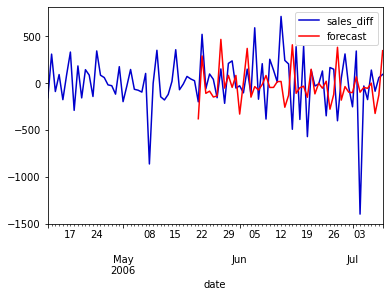

In [5]:
def sarimax_model(data):
    
    # Model
    sar = sm.tsa.statespace.SARIMAX(ts_data.sales_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()

    # Predictions
    start, end, dynamic = 40, 100, 7
    data['forecast'] = sar.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start+dynamic:end]
    
    data[['sales_diff', 'forecast']].plot(color=['mediumblue', 'Red'])
    
    get_scores(data)

    return sar, data, pred_df

sar, ts_data, predictions = sarimax_model(ts_data)

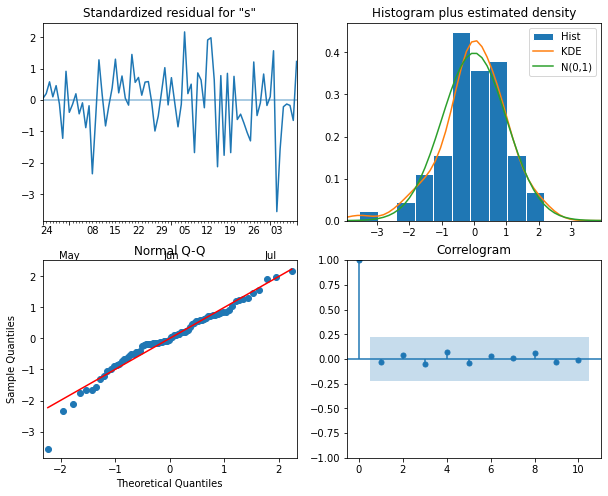

In [6]:
sar.plot_diagnostics(figsize=(10, 8));

# Plot Results

In [7]:
def predict_df(prediction_df):
    
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('../data/train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(prediction_df)):
        result_dict = {}
        result_dict['pred_value'] = int(prediction_df[index] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result, original_df

In [8]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    

    plt.savefig(f'../model_output/{model_name}_forecast.png')

In [9]:
prediction_df, original_df = predict_df(predictions)
plot_results(prediction_df, original_df, 'arima')

IndexError: list index out of range

We can also get dynamic predictions. One-step-ahead prediction uses the true values of the endogenous values at each step to predict the next in-sample value. Dynamic predictions use one-step-ahead prediction up to some point in the dataset (specified by the dynamic argument); after that, the previous predicted endogenous values are used in place of the true endogenous values for each new predicted element.